# PDE Problem Data Generation

In [1]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random

# PDE
from utils_pde_2dpoisson import Poisson2D

# Viz
from utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uq_dropout import DropoutPINN
from utils_uq_mlp import MLPPINN
from utils_uq_vi import VIBPINN

# CP
from utils_uq_cp import CP

# Ensure reproducibility
import random, numpy as np, torch
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Using device: cpu
Using device: cpu


In [2]:
# Data Noise
data_noise = 0.05

# Define PDE
domain=((0.0, 1.0), (0.0, 1.0))
true_solution=lambda xy: torch.sin(math.pi * xy[..., 0:1]) * torch.sin(math.pi * xy[..., 1:2])
pde = Poisson2D(domain, true_solution)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(500, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(200, data_noise)

# Define CP

In [3]:
colloc_pt_num = 100

# Deterministic + CP

## Deterministic

ep     1 | L=8.06e+01 | data=4.89e-01 | pde=7.99e+01  ic=0.00e+00  bc=5.11e-02 | lr=3.00e-03


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


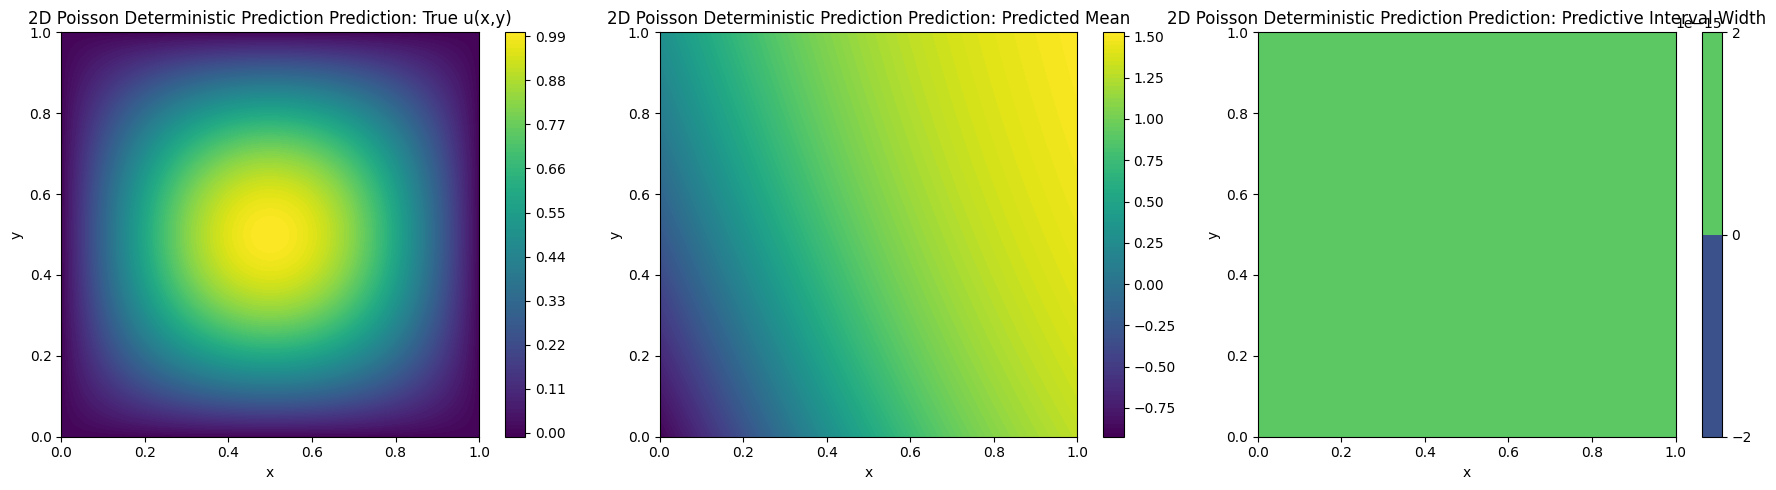

In [4]:
# --------------------------------------------
# 1. Build base model
# --------------------------------------------
MLP_model = MLPPINN(
    pde_class=pde, 
    input_dim=2, 
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    act_cls=nn.Tanh
)

# --------------------------------------------
# 2. Training
# --------------------------------------------
mlp_loss_dict =MLP_model.fit_mlp_pinn(
    coloc_pt_num=colloc_pt_num,
    X_train=X_train,
    Y_train=Y_train,
    λ_pde=1.0,
    λ_bc=5.0,
    λ_ic=0.0,
    epochs=10,
    lr=3e-3,
)

# --------------------------------------------
# 3. Prediction & Visulization
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Retrun a deterministic Prediction
pred_set = MLP_model.predict(
    alpha=0.05, 
    X_test=grid_test
) 

plot_predictions_2D(
    grid_test,
    pred_set,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)


##  Deterministic + CP

ep     1 | L=1.08e+02 | data=2.99e-01 | pde=1.08e+02  ic=0.00e+00  bc=2.88e-03 | lr=3.00e-03


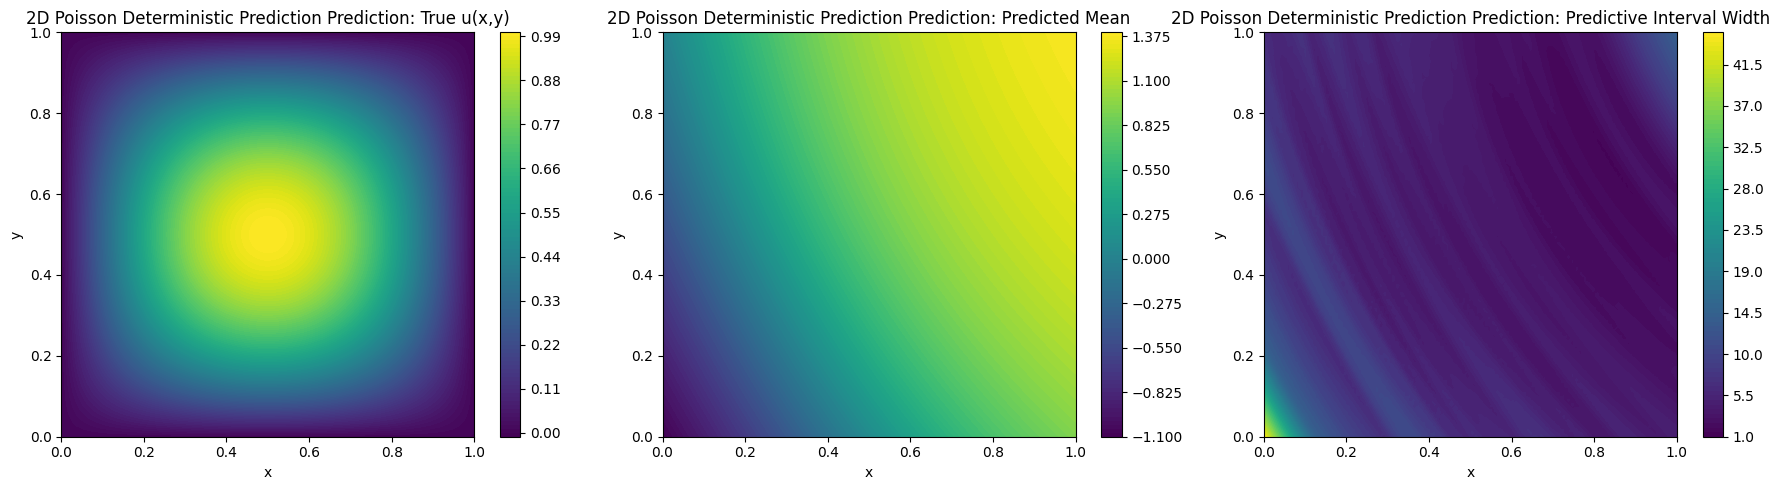

In [5]:
# --------------------------------------------
# 1. Build base model
# --------------------------------------------
MLP_model = MLPPINN(
    pde_class=pde, 
    input_dim=2, 
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    act_cls=nn.Tanh
)

# --------------------------------------------
# 2. Training
# --------------------------------------------
mlp_loss_dict =MLP_model.fit_mlp_pinn(
    coloc_pt_num=colloc_pt_num,
    X_train=X_train,
    Y_train=Y_train,
    λ_pde=1.0,
    λ_bc=5.0,
    λ_ic=0.0,
    epochs=10,
    lr=3e-3,
)

# --------------------------------------------
# 3. Prediction & Visulization
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Retrun a deterministic Prediction
pred_set = MLP_model.predict(
    alpha=0.05, 
    X_test=grid_test
) 

# plot_predictions_2D(
#     grid_test,
#     pred_set,
#     true_solution=pde.true_solution,
#     title="2D Poisson Deterministic Prediction Prediction"
# )


# CP
cp_deterministic = CP(model=MLP_model)
cp_predset = cp_deterministic.predict(
    alpha=0.05, 
    X_test=grid_test, 
    X_train=X_train, Y_train=Y_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, 
    heuristic_u="latent", k=20)

plot_predictions_2D(
    grid_test,
    cp_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)


In [6]:
from utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

rslt = cp_test_uncertainties(cp_deterministic, alphas, X_test, Y_test, X_calibration, Y_calibration, X_train, Y_train, heuristic_u="feature", k=10)

rslt

 38%|███▊      | 3/8 [00:00<00:00, 227.93it/s]


KeyboardInterrupt: 

## Metrics

### Coverage Plot

### Sharpness

# VI Models + CP

## VI Baseline

In [ ]:
# --------------------------------------------
# 2. Build base model
# --------------------------------------------
vi_model = VIBPINN(
    pde_class=pde, 
    input_dim=2,
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    mu_std = 0.01, rho = -5, prior_std=1.0, 
    init_data_noise=1.0, learn_data_noise=False, act_func=nn.Tanh()
)

# --------------------------------------------
# 3. Training
# --------------------------------------------
vi_loss_dict = vi_model.fit_vi_bpinn(
    coloc_pt_num=colloc_pt_num,
    X_train=X_train, Y_train=Y_train,
    λ_pde=5.0, λ_ic=1.0, λ_bc=10.0, λ_elbo=1.0, λ_data=1.0,
    epochs=30000, lr=3e-3,
    scheduler_cls=StepLR, scheduler_kwargs={'step_size': 5000, 'gamma': 0.5},
    stop_schedule=40000
)


ep     0 | L=6.10e+04 | elbo=1.66e+02 | pde=1.22e+04  ic=0.00e+00  bc=1.62e-04 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     1 | L=7.01e+04 | elbo=1.67e+02 | pde=1.40e+04  ic=0.00e+00  bc=8.00e-05 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   300 | L=4.11e+03 | elbo=8.49e+02 | pde=6.42e+02  ic=0.00e+00  bc=5.48e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   600 | L=3.26e+03 | elbo=6.61e+02 | pde=5.12e+02  ic=0.00e+00  bc=4.31e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   900 | L=2.65e+03 | elbo=5.97e+02 | pde=4.01e+02  ic=0.00e+00  bc=4.38e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1200 | L=2.00e+03 | elbo=6.23e+02 | pde=2.67e+02  ic=0.00e+00  bc=4.26e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1500 | L=3.20e+03 | elbo=6.44e+02 | pde=5.01e+02  ic=0.00e+00  bc=5.05e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  1800 | L=3.47e+03 | elbo=5.39e+02 | pde=5.78e+02  ic=0.00e+00  bc=4.04e+00 | lr=3.00e-03 | learned noise_std=1.000e+00
ep  2100 | L=2.9

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


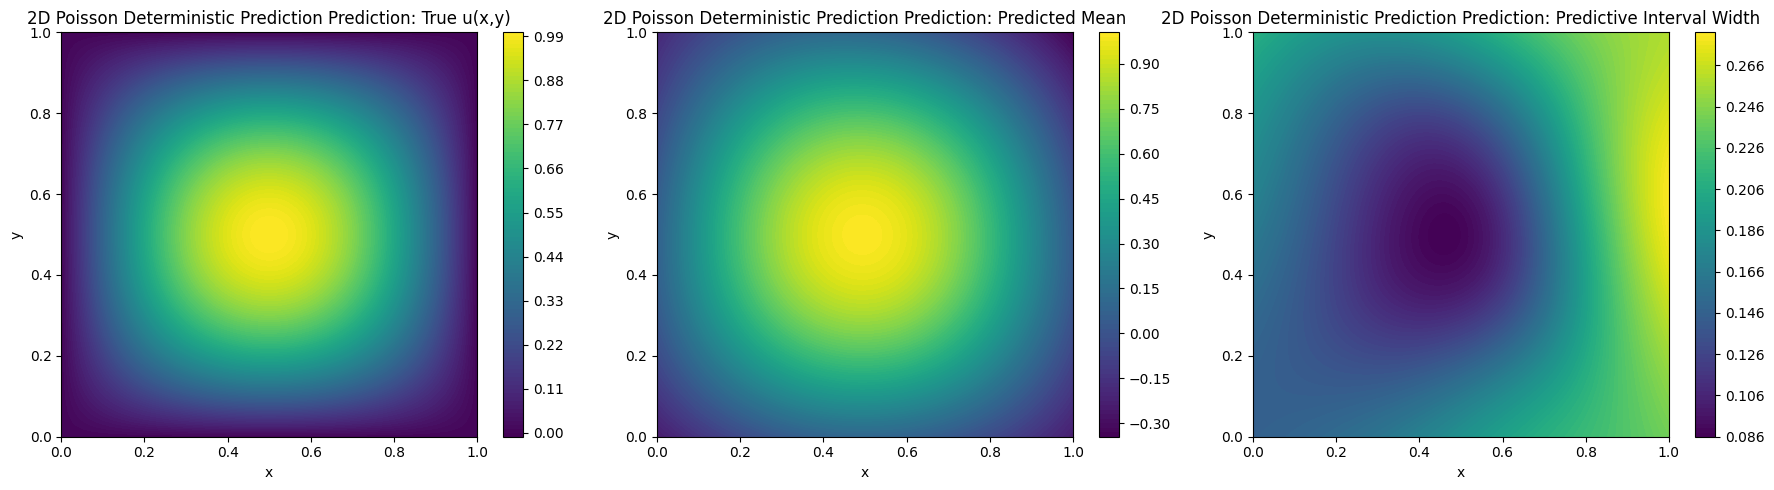

In [ ]:
# --------------------------------------------
# 3. Prediction & Visulization
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Retrun a deterministic Prediction
vi_uncal_predset = vi_model.predict(
    alpha=0.05, 
    X_test=grid_test, 
    n_samples=100,) 

plot_predictions_2D(
    grid_test,
    vi_uncal_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)

## VI + CP

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


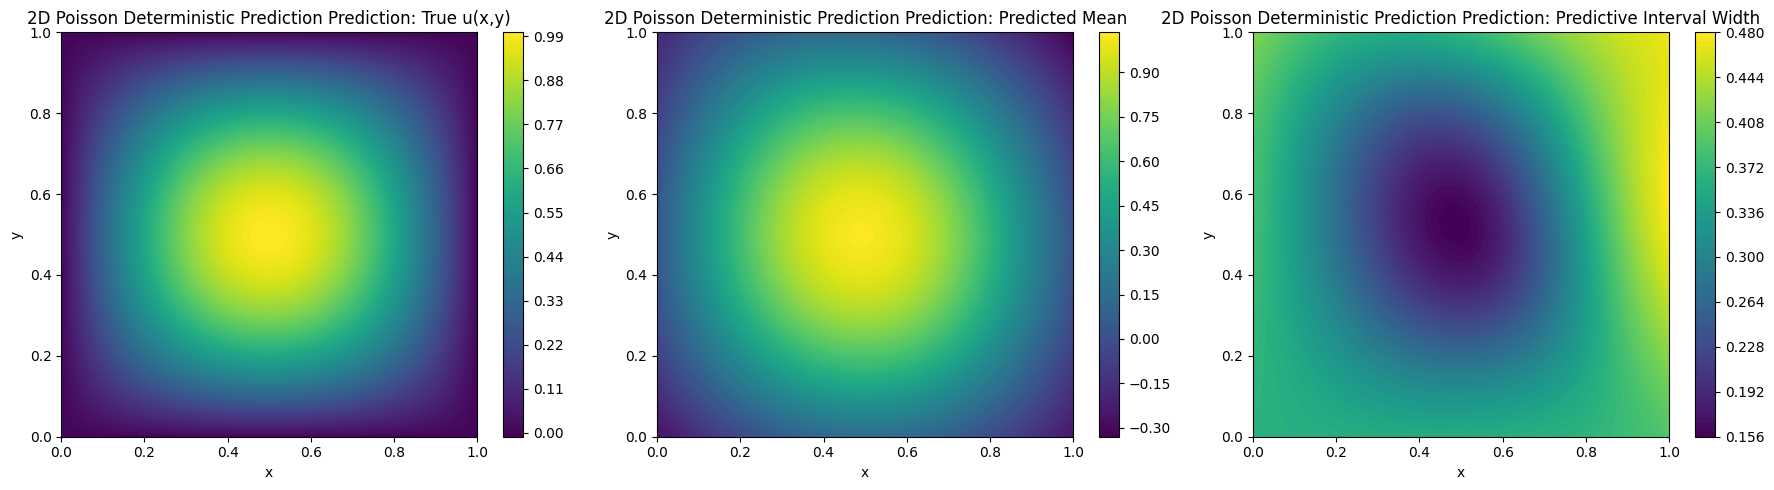

In [ ]:
# CP
cp_vi = CP(model=vi_model)
vi_cal_predset = cp_vi.predict(
    alpha=0.05,
    X_test=grid_test,
    X_train=X_train, Y_train=Y_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, 
    heuristic_u="raw_std")

plot_predictions_2D(
    grid_test,
    vi_cal_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)

# Metrics

In [ ]:
# --------------------------------------------
# 1. Uncalibrated model (Baseline)
# --------------------------------------------

from utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

vi_uncal_rslt = vi_test_uncertainties(
    vi_model, 
    alphas, 
    X_test, Y_test)

vi_uncal_rslt

100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


,alpha,coverage,sharpness
0,0.111111,0.68,0.142210
1,0.222222,0.57,0.110458
2,0.333333,0.49,0.088291
3,0.444444,0.44,0.070923
4,0.555556,0.33,0.049788
5,0.666667,0.27,0.037447
6,0.777778,0.13,0.025471
7,0.888889,0.07,0.012413


In [ ]:
# --------------------------------------------
# 2. Calibrated model (Baseline)
# --------------------------------------------

from utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties

def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

vi_cal_rslt = cp_test_uncertainties(cp_vi, alphas, X_test, Y_test, X_calibration, Y_calibration, X_train, Y_train, heuristic_u="raw_std")

vi_cal_rslt

100%|██████████| 8/8 [01:10<00:00,  8.78s/it]


,alpha,coverage,sharpness
0,0.111111,0.89,0.253952
1,0.222222,0.78,0.194488
2,0.333333,0.68,0.152029
3,0.444444,0.58,0.117012
4,0.555556,0.45,0.085472
5,0.666667,0.34,0.056123
6,0.777778,0.23,0.034574
7,0.888889,0.13,0.016071


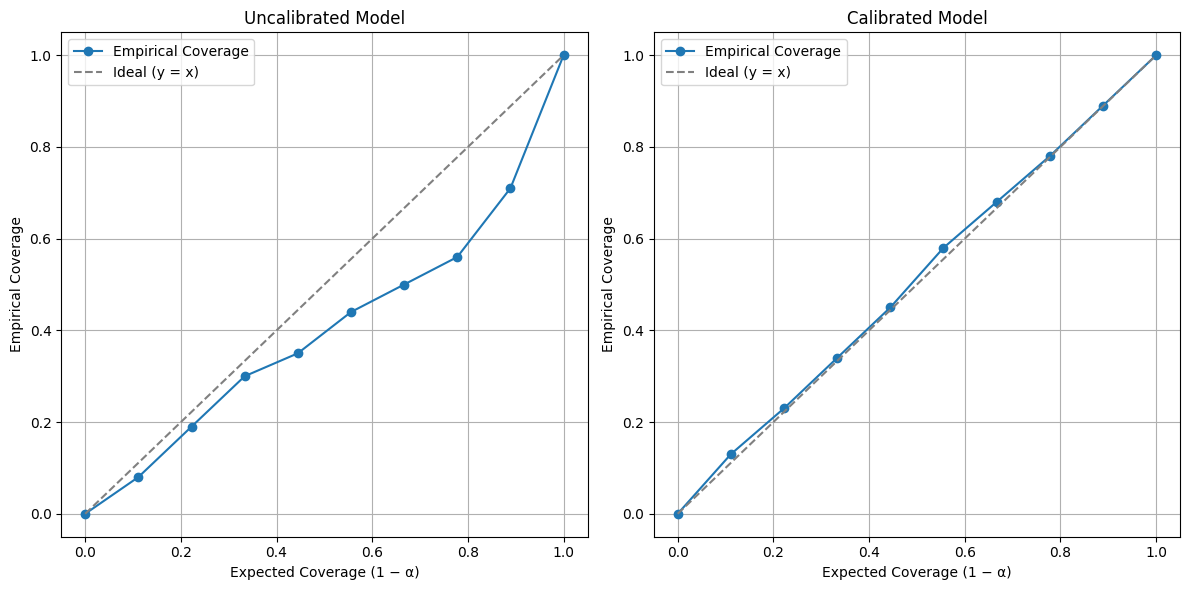

In [ ]:
# --------------------------------------------
# 3. Coverage Plot
# --------------------------------------------

from utils_result_viz import plot_dual_expected_vs_empirical
plot_dual_expected_vs_empirical(df_uncal=vi_uncal_rslt, df_cal=vi_cal_rslt)

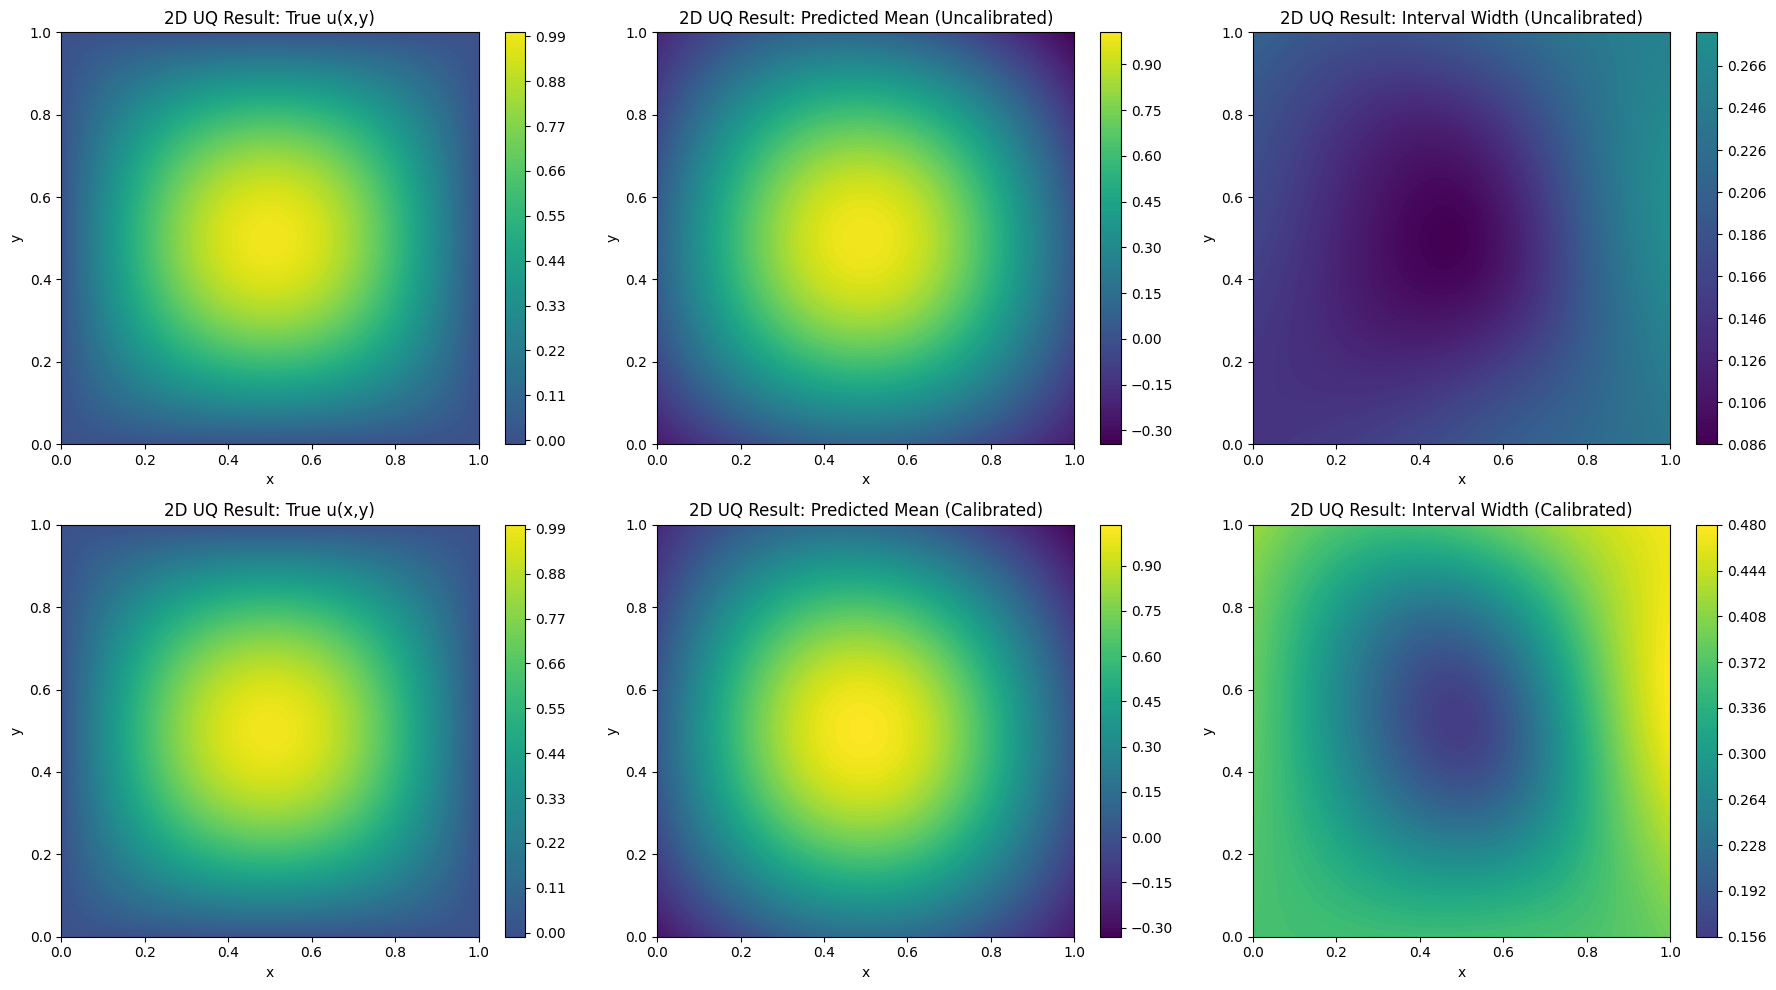

In [ ]:
from utils_result_viz import plot_predictions_2D_compare

plot_predictions_2D_compare(grid_test, vi_uncal_predset, vi_cal_predset, true_solution, title="2D UQ Result")

# Dropout Model + CP

## Dropout Baseline

In [ ]:
# --------------------------------------------
# 2. Build base model
# --------------------------------------------
do_pinn = DropoutPINN(
    pde_class=pde, 
    input_dim=2,
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    p_drop=0.1
)

# --------------------------------------------
# 3. Training
# --------------------------------------------
vi_loss_dict = do_pinn.fit_do_pinn(
    coloc_pt_num=colloc_pt_num,
    X_train=X_train, Y_train=Y_train,
    λ_pde=5.0, λ_ic=1.0, λ_bc=10.0, λ_data=1.0,
    epochs=20000, lr=3e-3,
    scheduler_cls=StepLR, scheduler_kwargs={'step_size': 5000, 'gamma': 0.5},
    stop_schedule=40000
)


ep     1 | L=4.78e+02 | data=2.60e-01 | pde=9.56e+01  ic=0.00e+00  bc=1.17e-03 | lr=3.00e-03


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


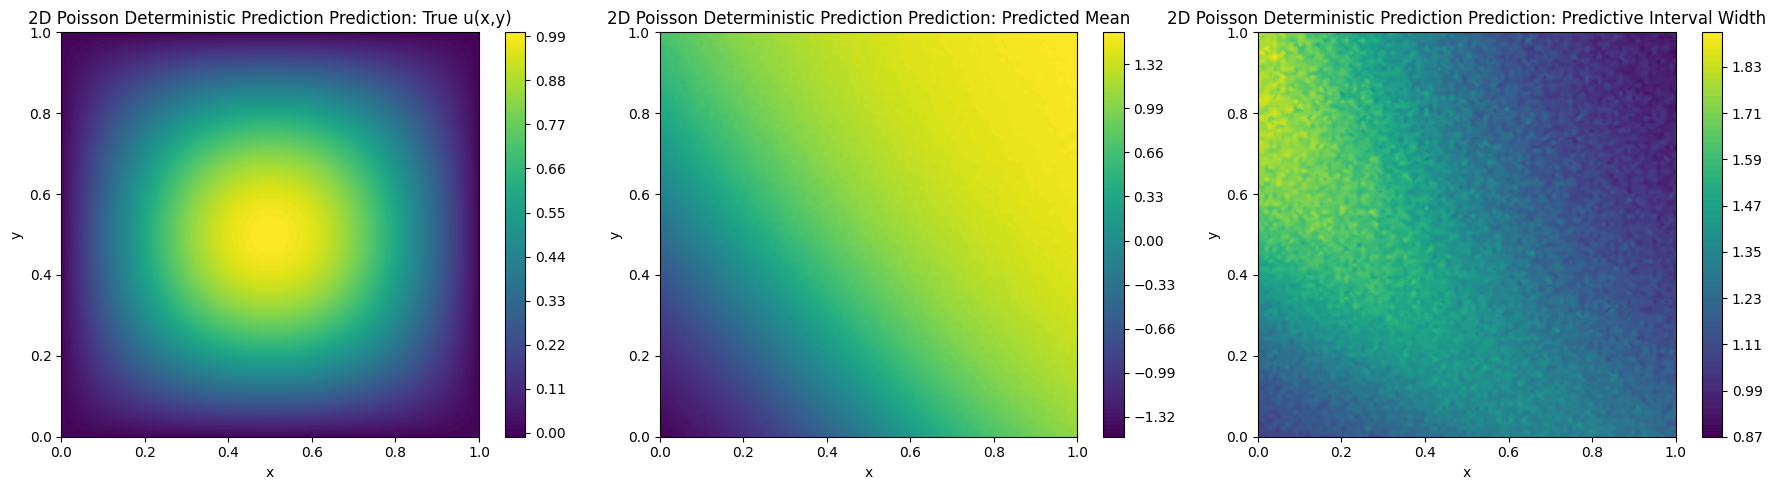

In [17]:
# --------------------------------------------
# 3. Prediction & Visulization
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Retrun a deterministic Prediction
cp_uncal_predset = do_pinn.predict(
    alpha=0.05, 
    X_test=grid_test,
    n_samples = 1000,

) 

plot_predictions_2D(
    grid_test,
    cp_uncal_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)

## Dropout + CP

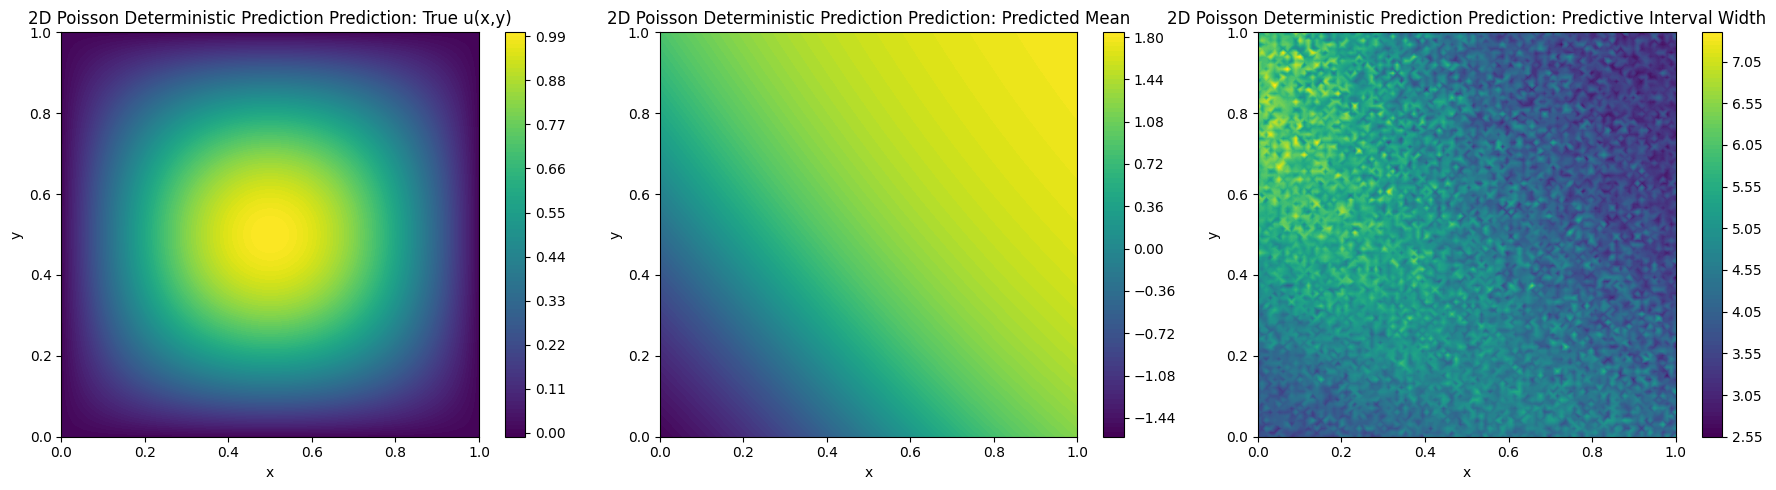

In [18]:
# CP
cp_do = CP(model=do_pinn)
cp_cal_predset = cp_do.predict(
    alpha=0.05,
    X_test=grid_test,
    X_train=X_train, Y_train=Y_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, 
    heuristic_u="raw_std")

plot_predictions_2D(
    grid_test,
    cp_cal_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)

# Metrics

In [19]:
# --------------------------------------------
# 1. Uncalibrated model (Baseline)
# --------------------------------------------

from utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

vi_uncal_rslt = do_test_uncertainties(
    do_pinn, 
    alphas, 
    X_test, Y_test,
    n_samples=1000
)

vi_uncal_rslt

100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


,alpha,coverage,sharpness
0,0.111111,0.43,1.077089
1,0.222222,0.37,0.820325
2,0.333333,0.28,0.652322
3,0.444444,0.23,0.514701
4,0.555556,0.20,0.396471
5,0.666667,0.13,0.291677
6,0.777778,0.08,0.190261
7,0.888889,0.06,0.094562


In [20]:
# --------------------------------------------
# 2. Calibrated model (Baseline)
# --------------------------------------------

from utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties

def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

vi_cal_rslt = cp_test_uncertainties(cp_do, alphas, X_test, Y_test, X_calibration, Y_calibration, X_train, Y_train, heuristic_u="raw_std")

vi_cal_rslt

  0%|          | 0/8 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 8/8 [00:00<00:00,  9.28it/s]


,alpha,coverage,sharpness
0,0.111111,0.92,3.726938
1,0.222222,0.78,2.913449
2,0.333333,0.69,2.401853
3,0.444444,0.56,1.827970
4,0.555556,0.47,1.350176
5,0.666667,0.38,1.014666
6,0.777778,0.27,0.708291
7,0.888889,0.11,0.286383


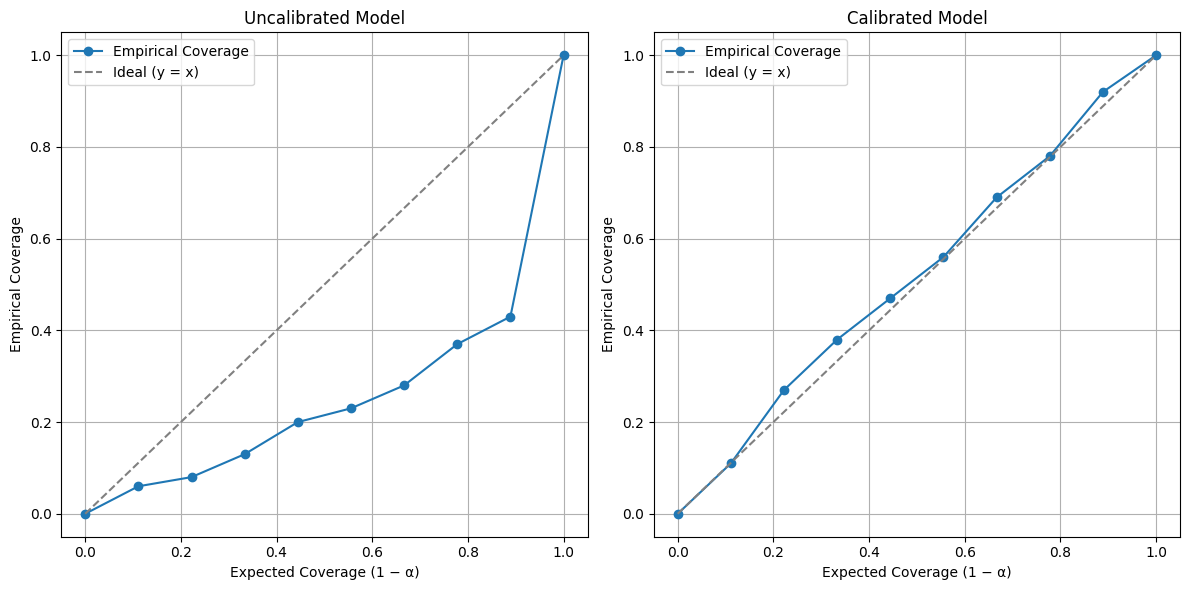

In [21]:
# --------------------------------------------
# 3. Coverage Plot
# --------------------------------------------

from utils_result_viz import plot_dual_expected_vs_empirical
plot_dual_expected_vs_empirical(df_uncal=vi_uncal_rslt, df_cal=vi_cal_rslt)

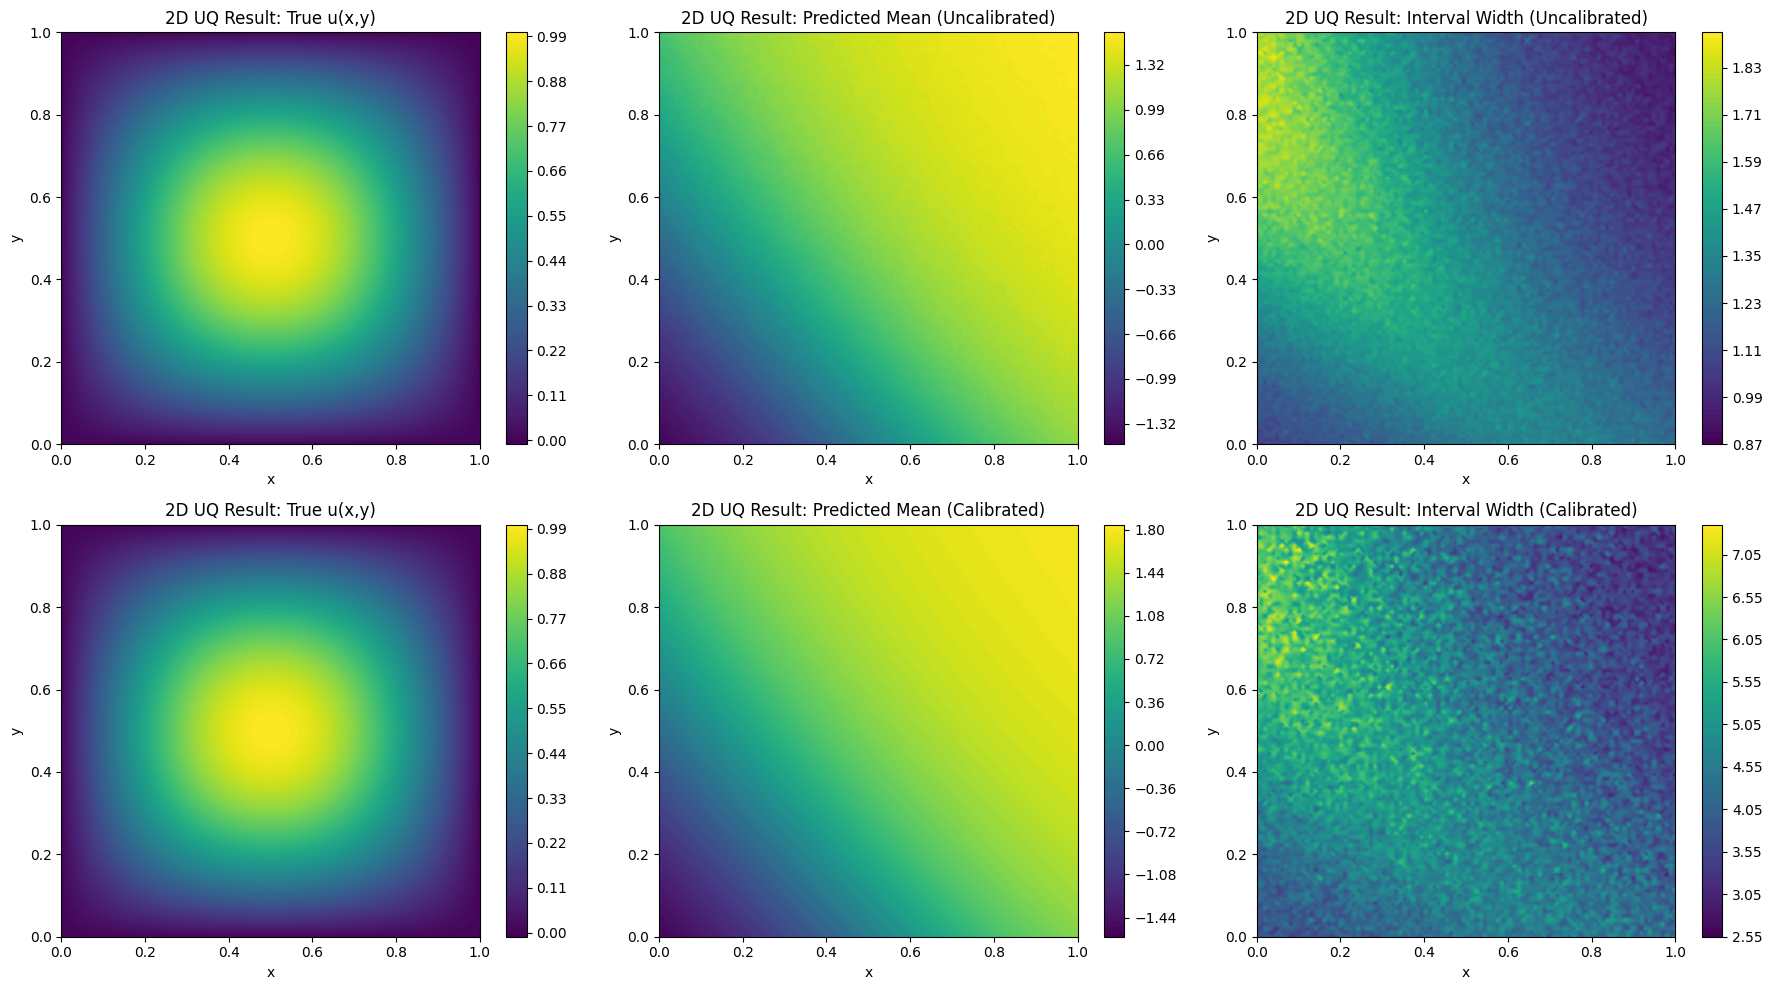

In [ ]:
from utils_result_viz import plot_predictions_2D_compare

plot_predictions_2D_compare(grid_test, cp_uncal_predset, cp_cal_predset, true_solution, title="2D UQ Result")